집값을 예측하는 모델을 만들기 위해 라이브러리를 생성한다.

In [522]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_squared_log_error as MSLE

!pip install eli5
import eli5 
from eli5.sklearn import PermutationImportance

!pip install xgboost==1.4.1
import xgboost as xgb
print(xgb.__version__)

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

1.4.1


필요한 데이터를 불러온다.

In [523]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [524]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/house_prices/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/house_prices/test.csv')

In [525]:
print(train.shape)
train.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [526]:
print(test.shape)
test.head()

(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [527]:
train.set_index('Id', inplace=True)
test.set_index('Id', inplace=True)
train_label = train['SalePrice']

train.drop(['SalePrice'], axis=1, inplace=True)
total = pd.concat([train, test], axis=0)
print(total.shape)
total.head()

(2919, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


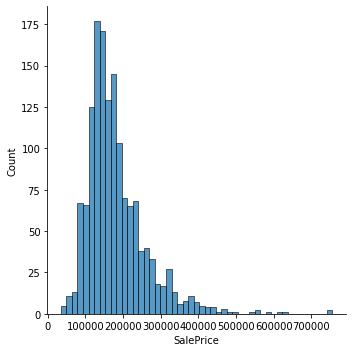

In [528]:
sns.displot(train_label)
plt.show()

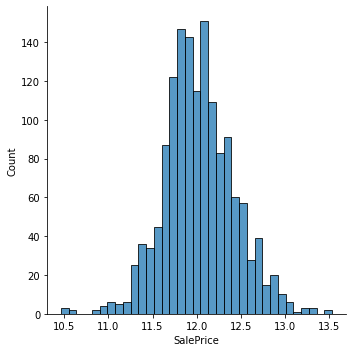

In [529]:
train_label = np.log1p(train_label)
sns.displot(train_label)
plt.show()

In [530]:
# 결측치가 있는 특성 찾기
null_total = total.isnull().sum()/len(total)
null_total.sort_values(ascending=False, inplace=True)
null_total[null_total > 0]

PoolQC          0.996574
MiscFeature     0.964029
Alley           0.932169
Fence           0.804385
FireplaceQu     0.486468
LotFrontage     0.166495
GarageCond      0.054471
GarageQual      0.054471
GarageYrBlt     0.054471
GarageFinish    0.054471
GarageType      0.053786
BsmtCond        0.028092
BsmtExposure    0.028092
BsmtQual        0.027749
BsmtFinType2    0.027407
BsmtFinType1    0.027064
MasVnrType      0.008222
MasVnrArea      0.007879
MSZoning        0.001370
BsmtHalfBath    0.000685
Utilities       0.000685
Functional      0.000685
BsmtFullBath    0.000685
BsmtFinSF2      0.000343
BsmtFinSF1      0.000343
Exterior2nd     0.000343
BsmtUnfSF       0.000343
TotalBsmtSF     0.000343
Exterior1st     0.000343
SaleType        0.000343
Electrical      0.000343
KitchenQual     0.000343
GarageArea      0.000343
GarageCars      0.000343
dtype: float64

In [531]:
# Categoical Feature의 결측치에 None을 채운다.
for col in ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
            'GarageCond', 'GarageQual', 'GarageType', 'GarageFinish',
            'BsmtCond', 'BsmtExposure', 'BsmtQual', 'BsmtFinType1',
            'BsmtFinType2', 'MasVnrType']:
    total[col].fillna('None', inplace=True)

# Numerical Feature의 결측치에 0을 채운다.
for col in ['GarageArea', 'GarageCars', 'MasVnrArea', 'BsmtHalfBath', 'BsmtFullBath',
            'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']:
    total[col].fillna(0, inplace=True)

# LotFrontage의 결측치에 Neighborhood를 기준으로 평균값을 채운다.
total['LotFrontage'].fillna(total.groupby('Neighborhood')['LotFrontage'].transform('mean'), inplace=True)

# 가장 많은 값을 채워넣는다.
for col in ['MSZoning', 'Functional', 'Exterior1st', 'Exterior2nd',
            'SaleType', 'Electrical', 'KitchenQual']:
    total[col].fillna(total[col].mode()[0], inplace=True)

# 특성을 제거한다.
for col in ['Utilities', 'Street', 'PoolQC', 'MiscVal']:
    total.drop([col], axis=1, inplace=True)

In [532]:
# 연도에 관련된 특성을 판매연도 특성과 조합해서 새로운 특성을 추가한다.
total['YrSoldSinceYearBuilt'] = total['YrSold'] - total['YearBuilt']
total['YrSoldSinceYearRemodAdd'] = total['YrSold'] - total['YearRemodAdd']
total['YrSoldSinceGarageYrBlt'] = total['YrSold'] - total['GarageYrBlt']

for col in ['YrSoldSinceYearBuilt', 'YrSoldSinceYearRemodAdd', 'YrSoldSinceGarageYrBlt']:
    total[col] = total[col].apply(lambda x: x if x > 0 else 0)

total.drop(['YrSold', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt'], axis=1, inplace=True)

In [533]:
# Categorical Feature로 바꾼다.
for col in ['MSSubClass', 'OverallCond', 'MoSold']:
    total[col] = total[col].apply(str)

In [534]:
# 특성을 조합해서 새로운 특성을 추가한다.
total['TotalSqrFootage'] = total['BsmtFinSF1'] + total['BsmtFinSF2'] + total['1stFlrSF'] + total['2ndFlrSF']
total['TotalBathrooms'] = total['FullBath'] + 0.5 * total['HalfBath'] + total['BsmtFullBath'] + 0.5 * total['BsmtHalfBath']
total['TotalHouse'] = total['TotalBsmtSF'] + total['1stFlrSF'] + total['2ndFlrSF']
total['TotalArea'] = total['TotalBsmtSF'] + total['1stFlrSF'] + total['2ndFlrSF'] + total['GarageArea']
total['TotalPorchSF'] = total['OpenPorchSF'] + total['3SsnPorch'] + total['EnclosedPorch'] + total['ScreenPorch'] + total['WoodDeckSF']
total['GrLivArea_OverallQual'] = total['GrLivArea'] * total['OverallQual']
total['LotArea_OverallQual'] = total['LotArea'] * total['OverallQual']

In [535]:
# 특성을 간소화한다.
total['Has_Pool'] = total['PoolArea'].apply(lambda x:1 if x > 0 else 0)
total['Has_Garage'] = total['GarageArea'].apply(lambda x:1 if x > 0 else 0)
total['Has_Bsmt'] = total['TotalBsmtSF'].apply(lambda x:1 if x > 0 else 0)
total['Has_Fireplaces'] = total['Fireplaces'].apply(lambda x:1 if x > 0 else 0)
total['Has_MasVnr'] = total['MasVnrArea'].apply(lambda x:1 if x > 0 else 0)
total['Has_BsmtFinSF1'] = total['BsmtFinSF1'].apply(lambda x:1 if x > 0 else 0)
total['Has_BsmtFinSF2'] = total['BsmtFinSF2'].apply(lambda x:1 if x > 0 else 0)
total['Has_WoodDeck'] = total['WoodDeckSF'].apply(lambda x:1 if x > 0 else 0)
total['Has_OpenPorch'] = total['OpenPorchSF'].apply(lambda x:1 if x > 0 else 0)
total['Has_EnclosedPorch'] = total['EnclosedPorch'].apply(lambda x:1 if x > 0 else 0)
total['Has_ScreenPorch'] = total['ScreenPorch'].apply(lambda x:1 if x > 0 else 0)
total['Has_2ndFloor'] = total['2ndFlrSF'].apply(lambda x:1 if x > 0 else 0)

# 사용된 특성을 제거한다.
total.drop(['BsmtFinSF1', 'BsmtFinSF2', '1stFlrSF', '2ndFlrSF', 'FullBath', 'HalfBath', 'BsmtFullBath',
            'BsmtHalfBath', 'TotalBsmtSF', 'GarageArea', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch',
            'ScreenPorch', 'WoodDeckSF', 'PoolArea', 'GarageArea', 'Fireplaces', 'MasVnrArea'], axis=1, inplace=True)

In [536]:
# 극단적인 특성은 제거한다.
total.drop(['LowQualFinSF'], axis=1, inplace=True)

In [537]:
# Categorical feature와 Numerical feature를 나눈다.
total_cat = total.select_dtypes(include='object')
total_num = total.select_dtypes(exclude='object')
print(total_cat.columns, total_num.columns, sep='\n')

Index(['MSSubClass', 'MSZoning', 'Alley', 'LotShape', 'LandContour',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallCond', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'Fence',
       'MiscFeature', 'MoSold', 'SaleType', 'SaleCondition'],
      dtype='object')
Index(['LotFrontage', 'LotArea', 'OverallQual', 'BsmtUnfSF', 'GrLivArea',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'GarageCars',
       'YrSoldSinceYearBuilt', 'YrSoldSinceYearRemodAdd',
       'YrSoldSinceGarageYrBlt', 'TotalSqrFootage', 'TotalBathrooms',
       'TotalHouse', 'TotalArea', 'TotalPorchSF', 'GrLivAr

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and ma

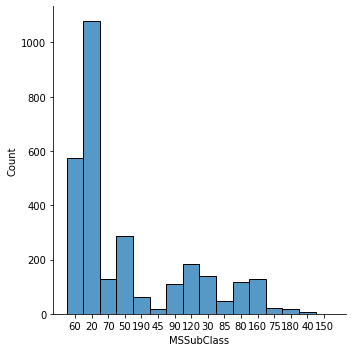

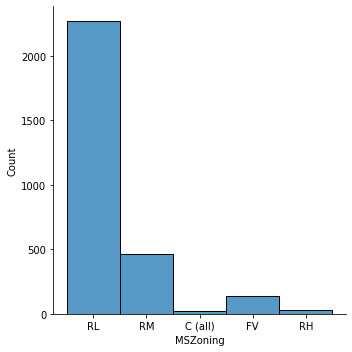

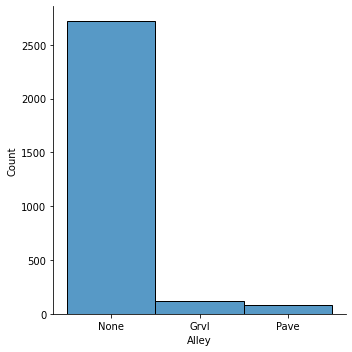

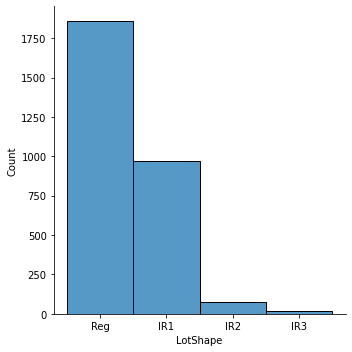

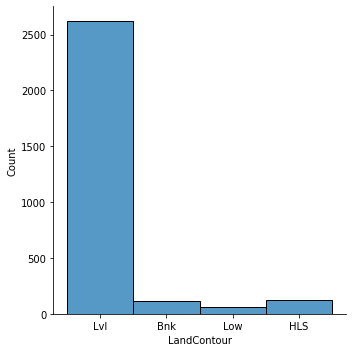

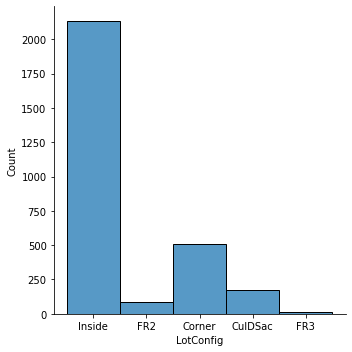

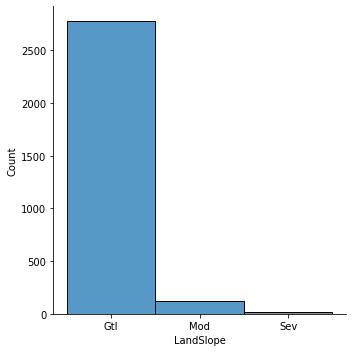

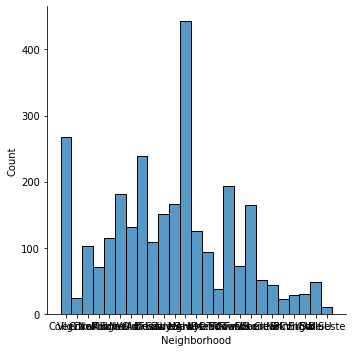

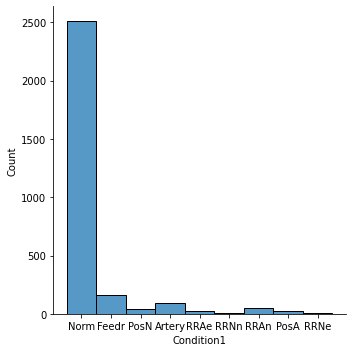

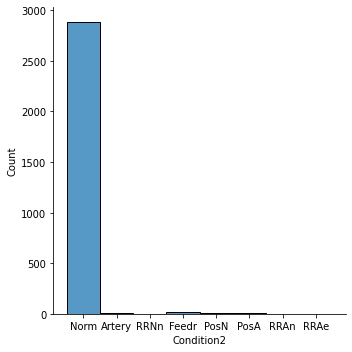

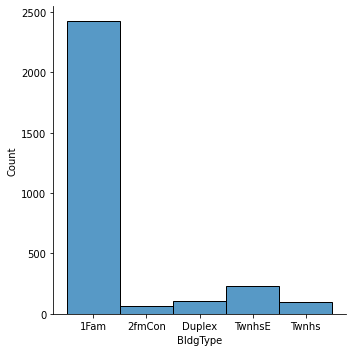

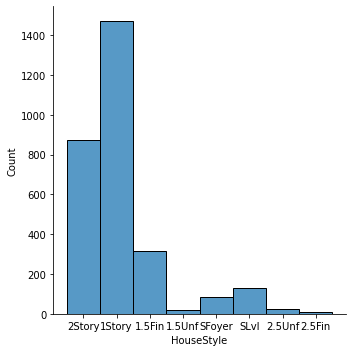

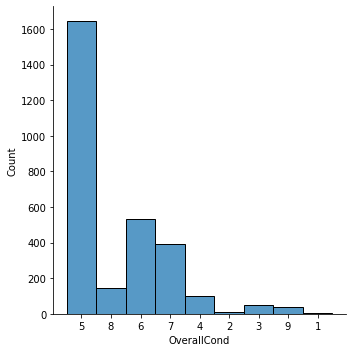

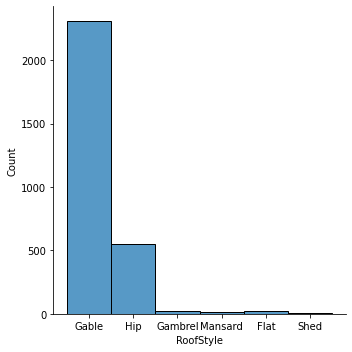

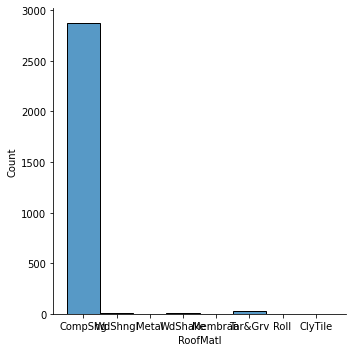

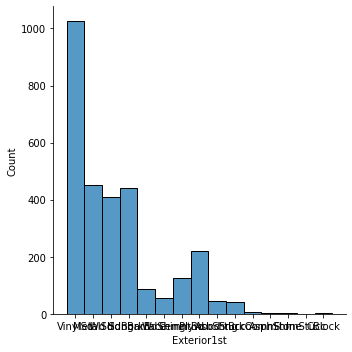

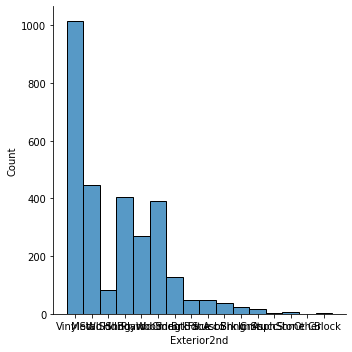

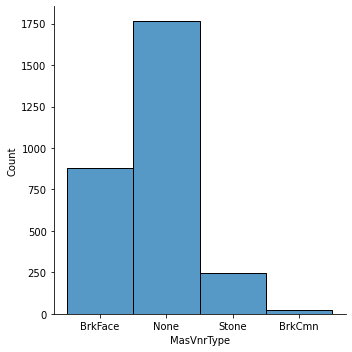

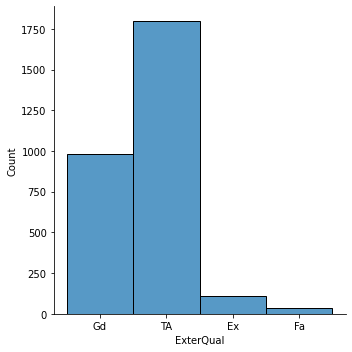

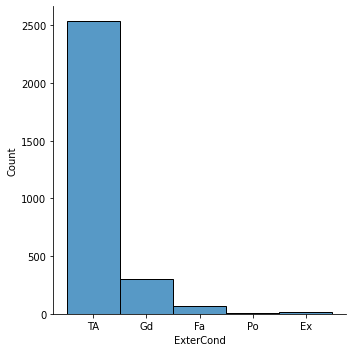

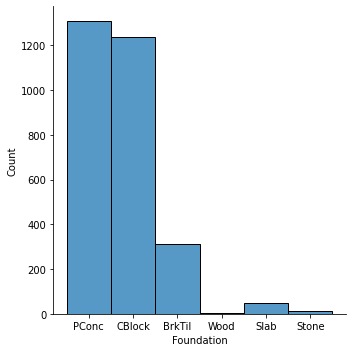

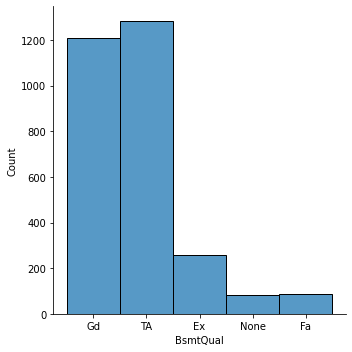

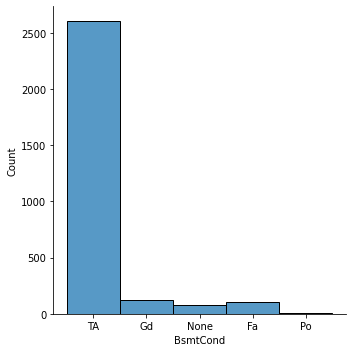

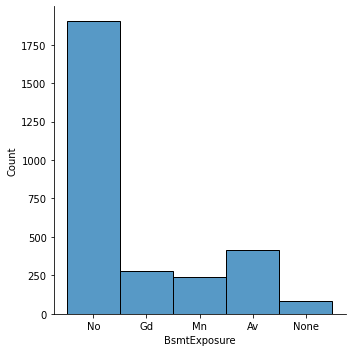

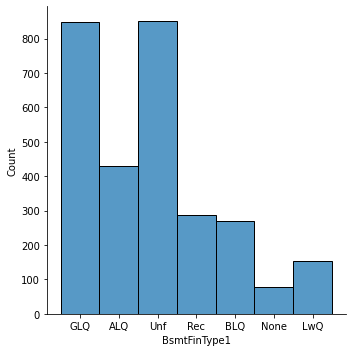

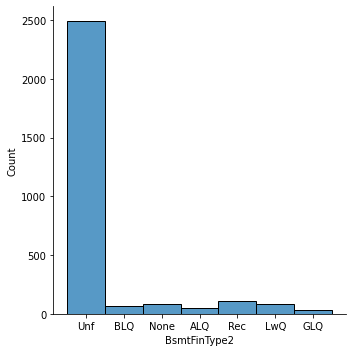

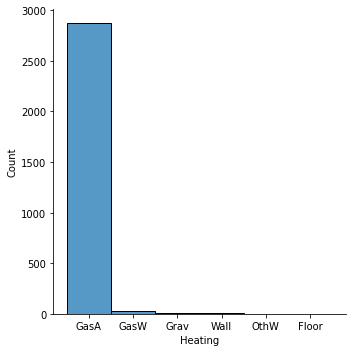

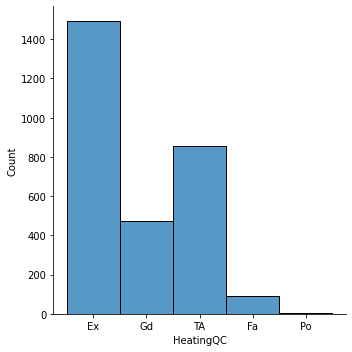

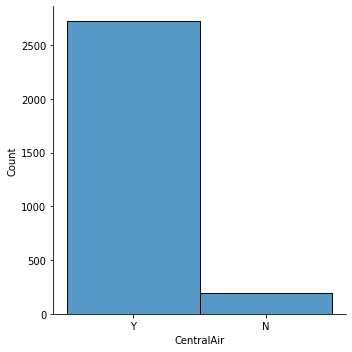

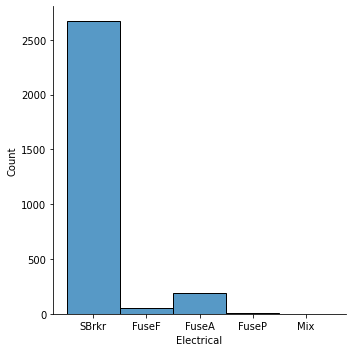

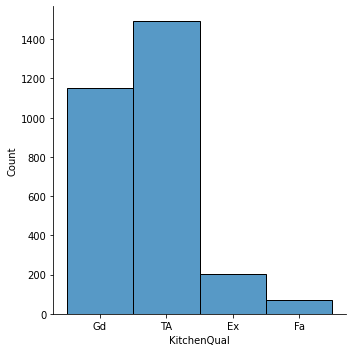

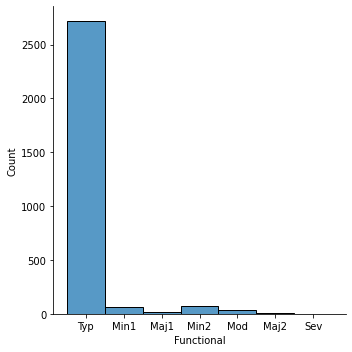

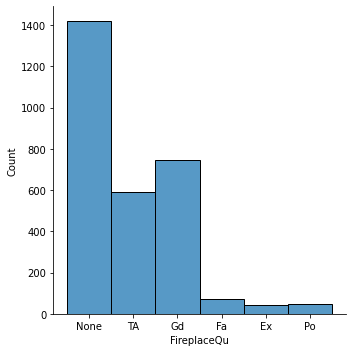

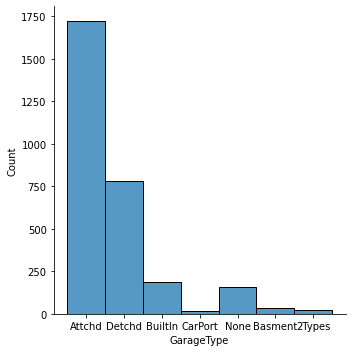

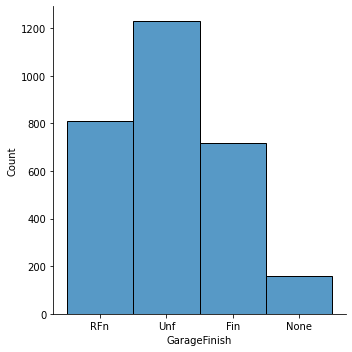

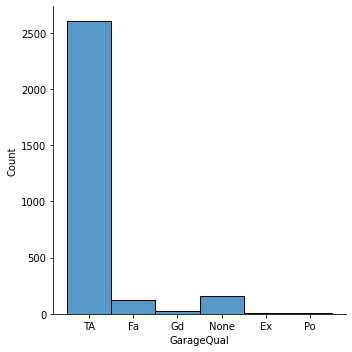

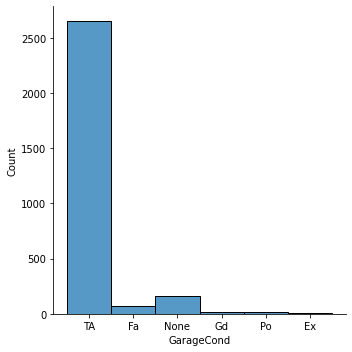

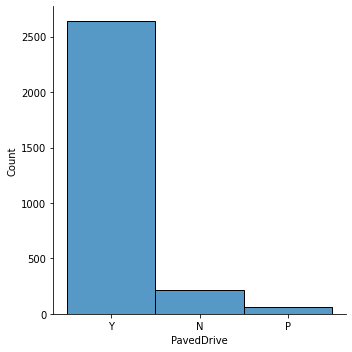

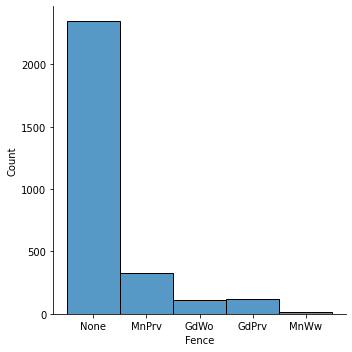

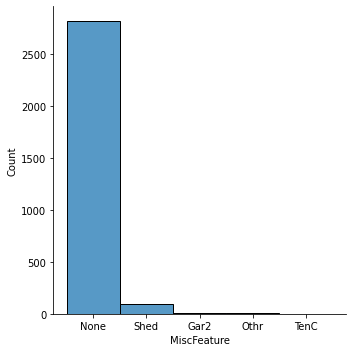

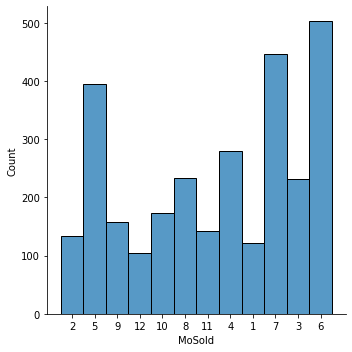

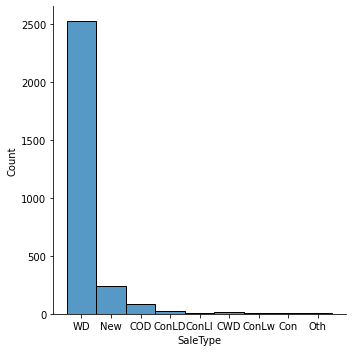

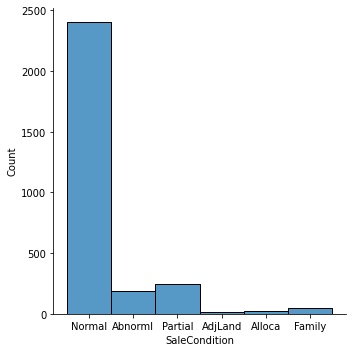

In [538]:
for col in total_cat:
    sns.displot(total[col])

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and ma

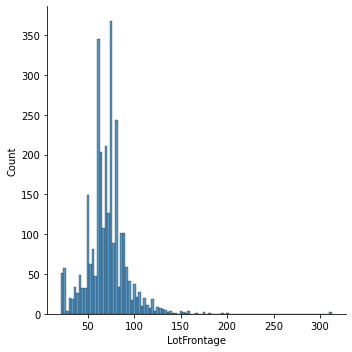

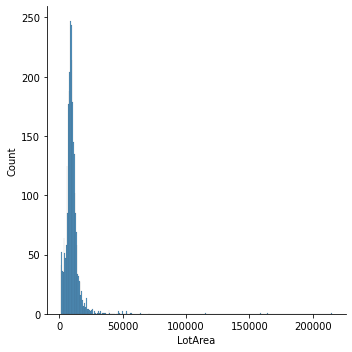

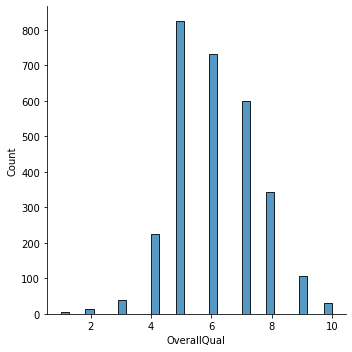

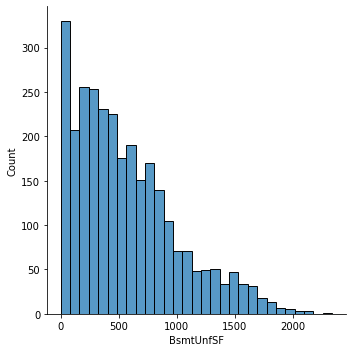

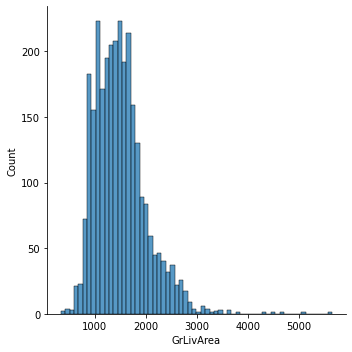

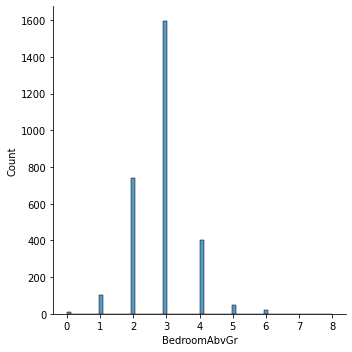

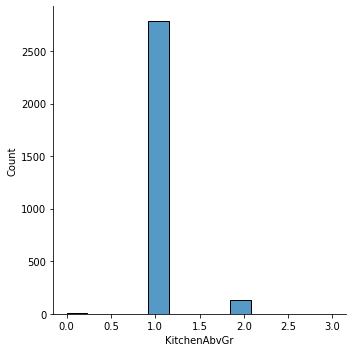

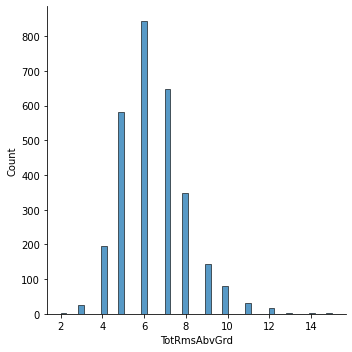

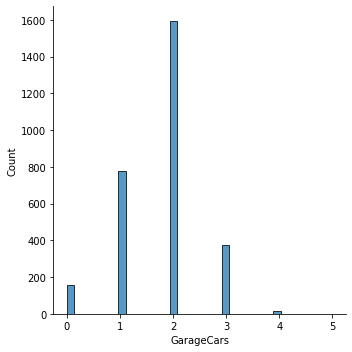

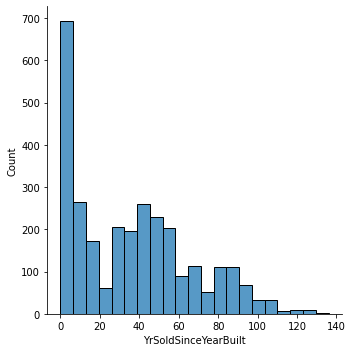

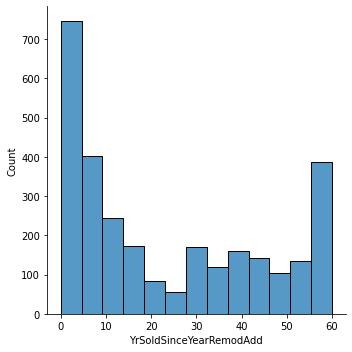

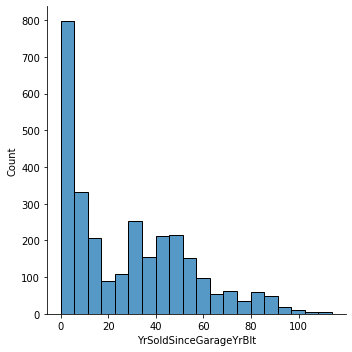

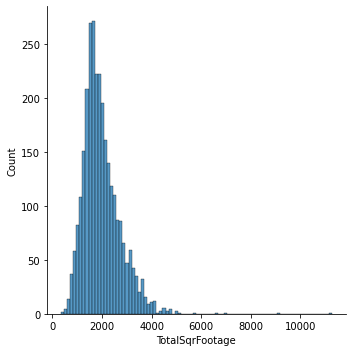

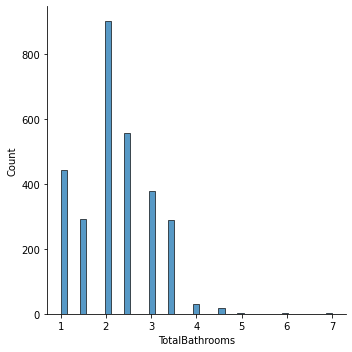

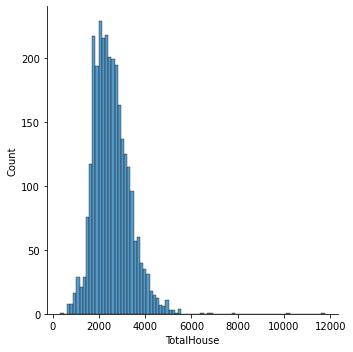

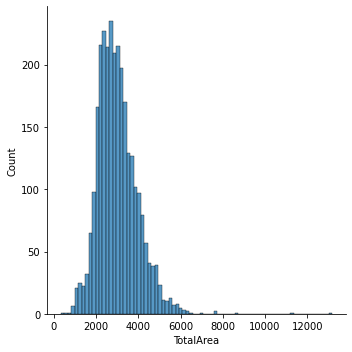

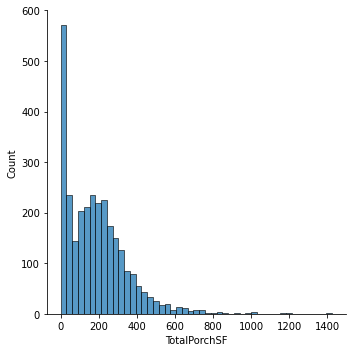

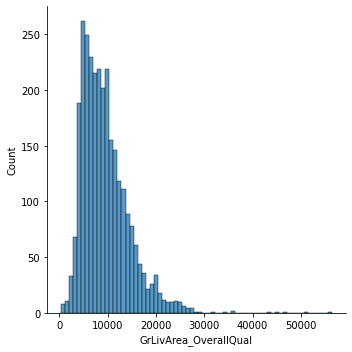

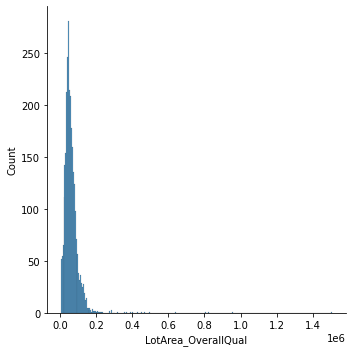

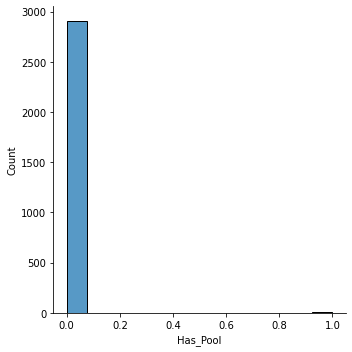

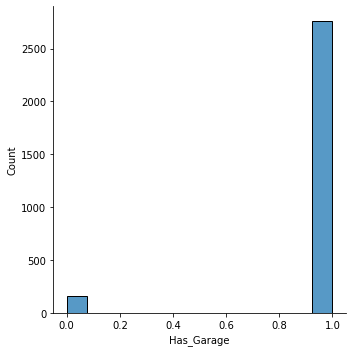

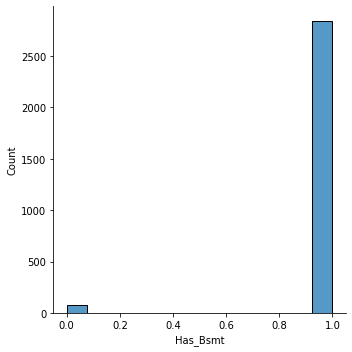

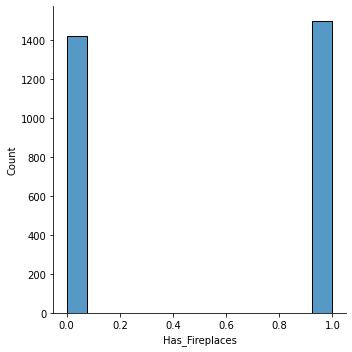

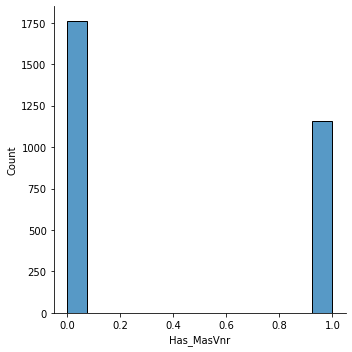

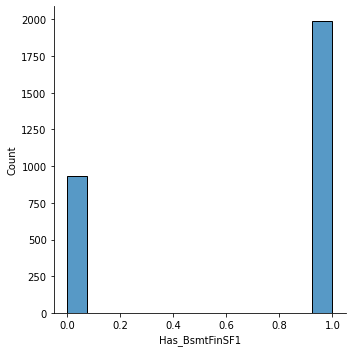

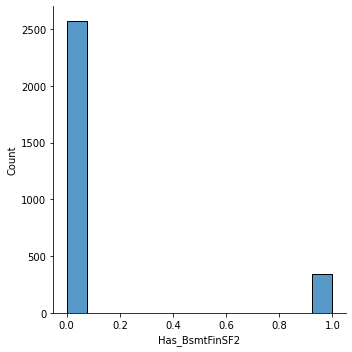

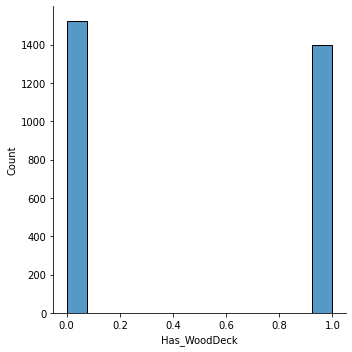

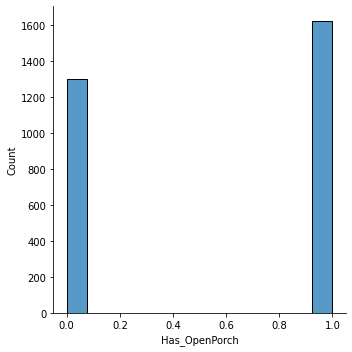

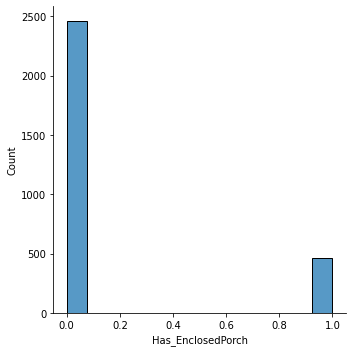

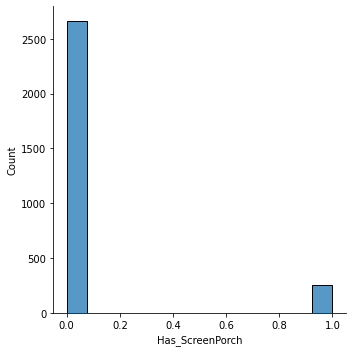

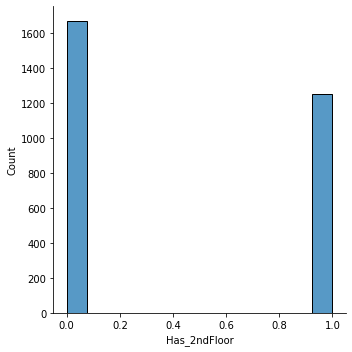

In [539]:
for col in total_num:
    sns.displot(total[col])

Has_Pool                  14.884318
LotArea                   12.822431
LotArea_OverallQual       11.265252
KitchenAbvGr               4.302254
Has_ScreenPorch            2.915215
Has_BsmtFinSF2             2.355211
Has_EnclosedPorch          1.883099
TotalSqrFootage            1.834437
GrLivArea_OverallQual      1.809139
TotalHouse                 1.511479
LotFrontage                1.460429
TotalPorchSF               1.376649
TotalArea                  1.304477
GrLivArea                  1.269358
BsmtUnfSF                  0.919339
TotRmsAbvGrd               0.758367
YrSoldSinceGarageYrBlt     0.710481
YrSoldSinceYearBuilt       0.598651
dtype: float64
Index(['Has_Pool', 'LotArea', 'LotArea_OverallQual', 'KitchenAbvGr',
       'Has_ScreenPorch', 'Has_BsmtFinSF2', 'Has_EnclosedPorch',
       'TotalSqrFootage', 'GrLivArea_OverallQual', 'TotalHouse', 'LotFrontage',
       'TotalPorchSF', 'TotalArea', 'GrLivArea', 'BsmtUnfSF', 'TotRmsAbvGrd',
       'YrSoldSinceGarageYrBlt', 'YrSoldSince

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3538: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interfa

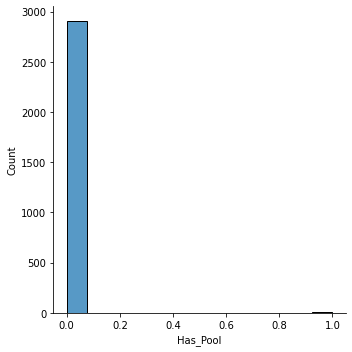

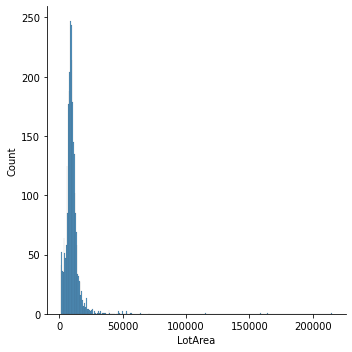

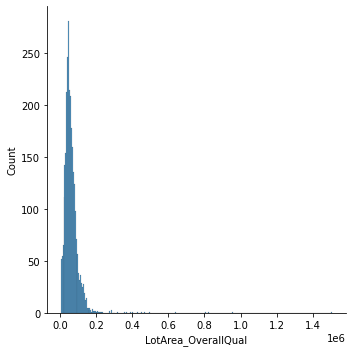

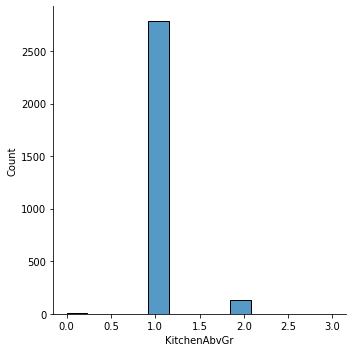

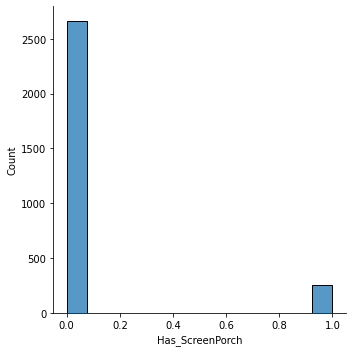

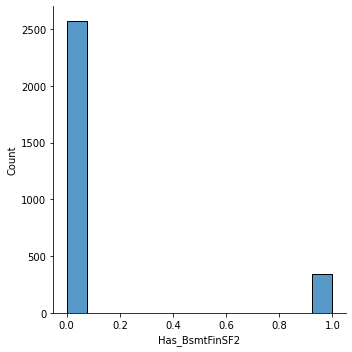

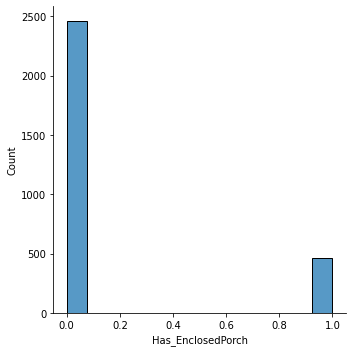

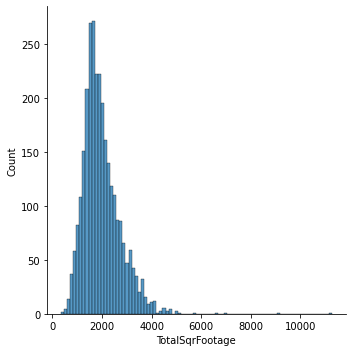

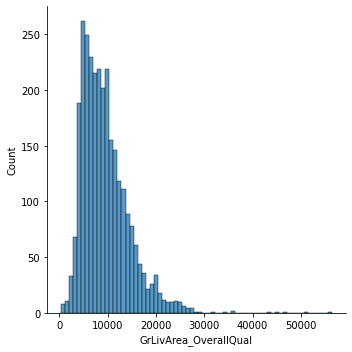

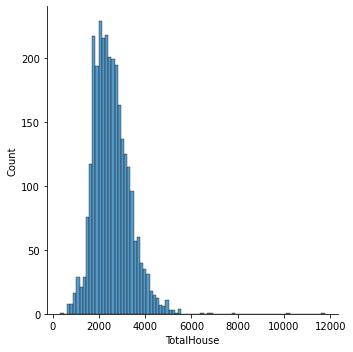

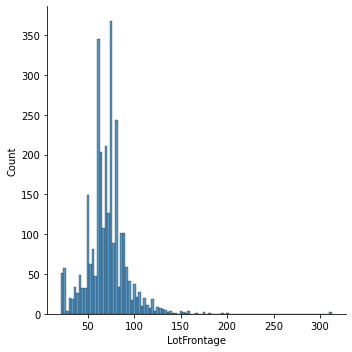

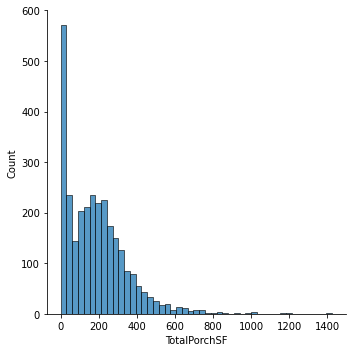

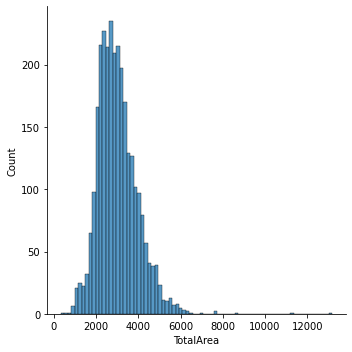

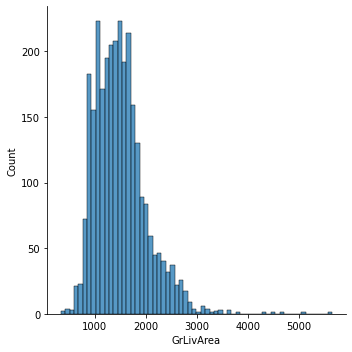

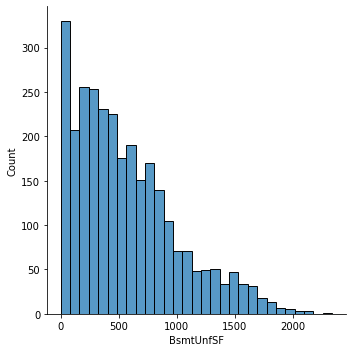

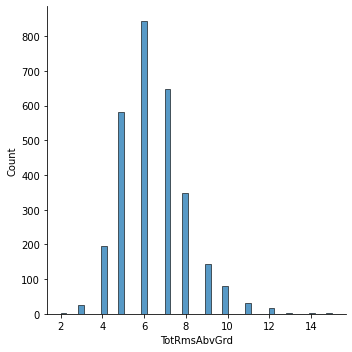

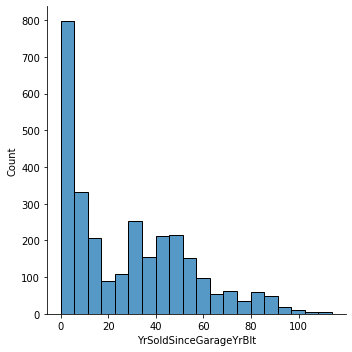

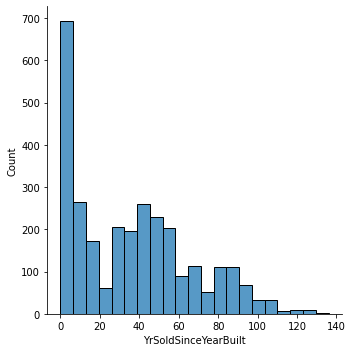

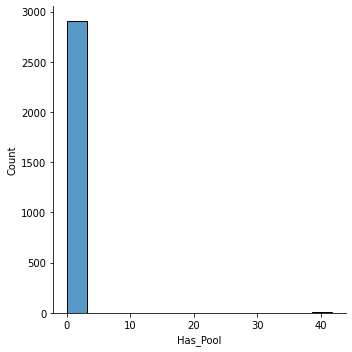

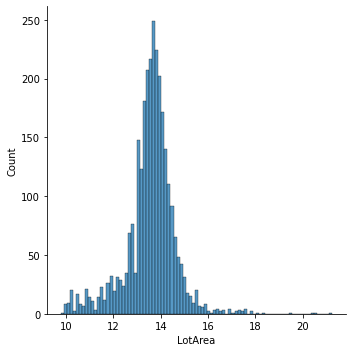

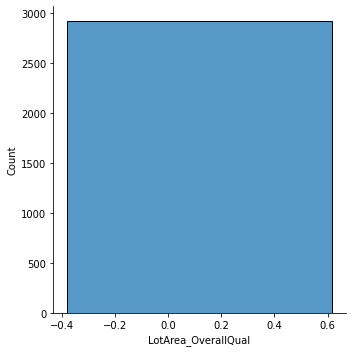

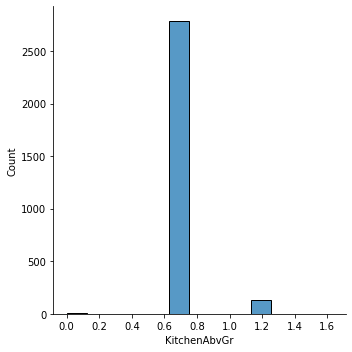

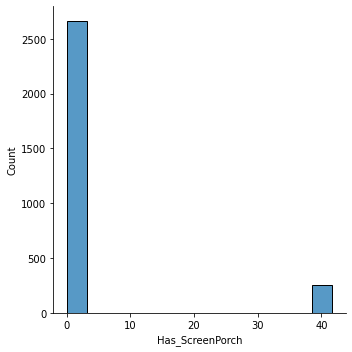

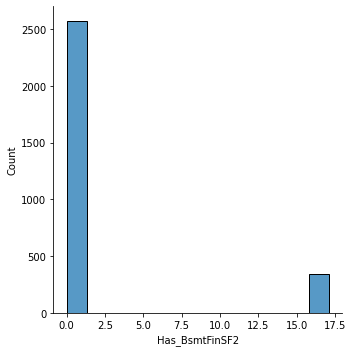

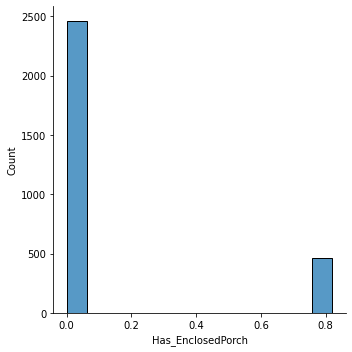

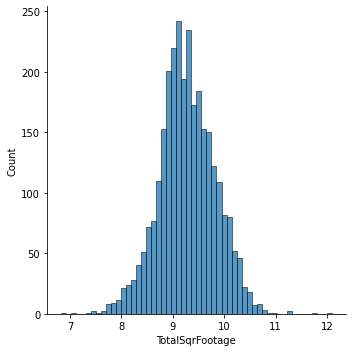

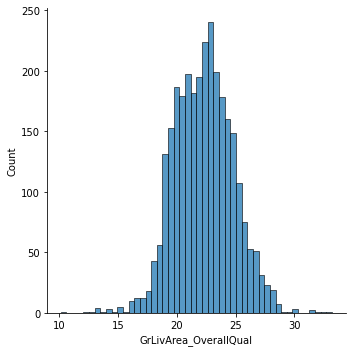

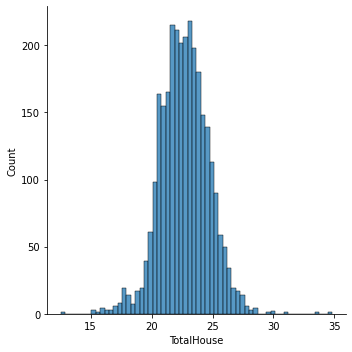

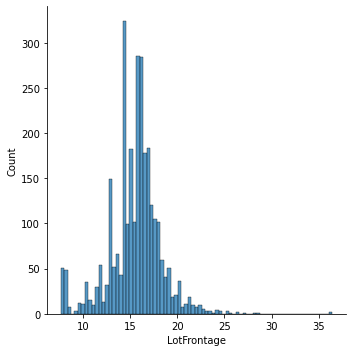

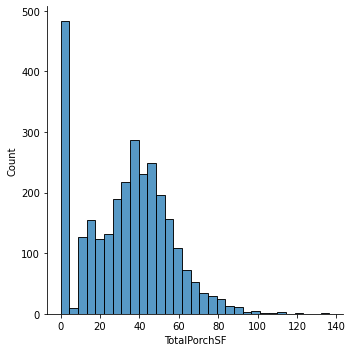

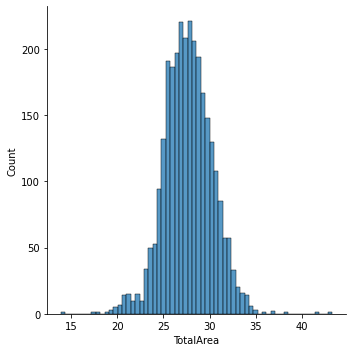

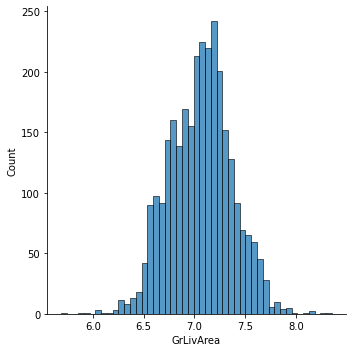

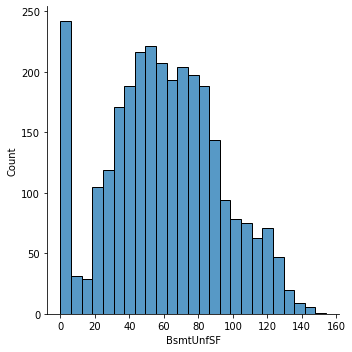

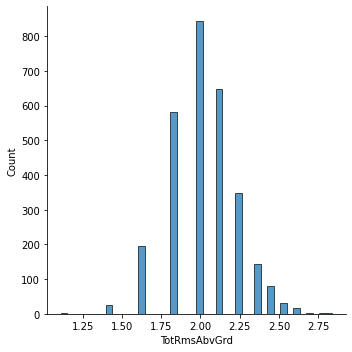

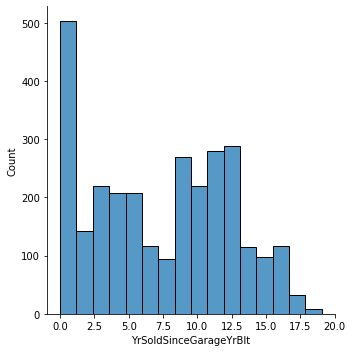

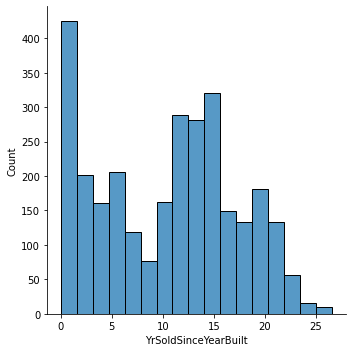

In [540]:
skew_features = total_num.apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index
print(high_skew, skew_index, sep='\n')
for col in skew_index:
    sns.displot(total[col])

for i in skew_index:
    total[i] = boxcox1p(total[i], boxcox_normmax(total[i] + 1))

for col in skew_index:
    sns.displot(total[col])

In [541]:
# for col in total_num:
#     figure = sns.displot(total[col])

In [542]:
# # Categorical feature에 One-hot encoding을 적용한다.
# total_cat_dummy = pd.get_dummies(total_cat, drop_first=True)
# total_cat_dummy.head()

from sklearn.preprocessing import LabelEncoder

label = LabelEncoder()
for col in total_cat.columns:
    total_cat[col] = label.fit_transform(total_cat[col])

total_cat[total_cat.columns].head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,MSSubClass,MSZoning,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,Fence,MiscFeature,MoSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,10,3,1,3,3,4,0,5,2,2,0,5,4,1,1,12,13,1,2,4,2,2,4,3,2,6,1,0,1,4,2,6,3,1,2,5,5,2,4,1,4,8,4
2,5,3,1,3,3,2,0,24,1,2,0,2,7,1,1,8,8,2,3,4,1,2,4,1,0,6,1,0,1,4,3,6,5,1,2,5,5,2,4,1,7,8,4
3,10,3,1,0,3,4,0,5,2,2,0,5,4,1,1,12,13,1,2,4,2,2,4,2,2,6,1,0,1,4,2,6,5,1,2,5,5,2,4,1,11,8,4
4,11,3,1,0,3,0,0,6,2,2,0,5,4,1,1,13,15,2,3,4,0,4,1,3,0,6,1,2,1,4,2,6,2,5,3,5,5,2,4,1,4,8,0
5,10,3,1,0,3,2,0,15,2,2,0,5,4,1,1,12,13,1,2,4,2,2,4,0,2,6,1,0,1,4,2,6,5,1,2,5,5,2,4,1,3,8,4


In [543]:
# Numerical feature와 Categorical feature를 다시 합친다.
total = pd.merge(total_cat, total_num, left_index=True, right_index=True)
print(total.shape)
total.head()

(2919, 74)


,MSSubClass,MSZoning,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,Fence,MiscFeature,MoSold,SaleType,SaleCondition,LotFrontage,LotArea,OverallQual,BsmtUnfSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,GarageCars,YrSoldSinceYearBuilt,YrSoldSinceYearRemodAdd,YrSoldSinceGarageYrBlt,TotalSqrFootage,TotalBathrooms,TotalHouse,TotalArea,TotalPorchSF,GrLivArea_OverallQual,LotArea_OverallQual,Has_Pool,Has_Garage,Has_Bsmt,Has_Fireplaces,Has_MasVnr,Has_BsmtFinSF1,Has_BsmtFinSF2,Has_WoodDeck,Has_OpenPorch,Has_EnclosedPorch,Has_ScreenPorch,Has_2ndFloor
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,10,3,1,3,3,4,0,5,2,2,0,5,4,1,1,12,13,1,2,4,2,2,4,3,2,6,1,0,1,4,2,6,3,1,2,5,5,2,4,1,4,8,4,65.0,8450,7,150.0,1710,3,1,8,2.0,5,5,5.0,2416.0,3.5,2566.0,3114.0,61,11970,59150,0,1,1,0,1,1,0,0,1,0,0,1
2,5,3,1,3,3,2,0,24,1,2,0,2,7,1,1,8,8,2,3,4,1,2,4,1,0,6,1,0,1,4,3,6,5,1,2,5,5,2,4,1,7,8,4,80.0,9600,6,284.0,1262,3,1,6,2.0,31,31,31.0,2240.0,2.5,2524.0,2984.0,298,7572,57600,0,1,1,1,0,1,0,1,0,0,0,0
3,10,3,1,0,3,4,0,5,2,2,0,5,4,1,1,12,13,1,2,4,2,2,4,2,2,6,1,0,1,4,2,6,5,1,2,5,5,2,4,1,11,8,4,68.0,11250,7,434.0,1786,3,1,6,2.0,7,6,7.0,2272.0,3.5,2706.0,3314.0,42,12502,78750,0,1,1,1,1,1,0,0,1,0,0,1
4,11,3,1,0,3,0,0,6,2,2,0,5,4,1,1,13,15,2,3,4,0,4,1,3,0,6,1,2,1,4,2,6,2,5,3,5,5,2,4,1,4,8,0,60.0,9550,7,540.0,1717,3,1,7,3.0,91,36,8.0,1933.0,2.0,2473.0,3115.0,307,12019,66850,0,1,1,1,0,1,0,0,1,1,0,1
5,10,3,1,0,3,2,0,15,2,2,0,5,4,1,1,12,13,1,2,4,2,2,4,0,2,6,1,0,1,4,2,6,5,1,2,5,5,2,4,1,3,8,4,84.0,14260,8,490.0,2198,4,1,9,3.0,8,8,8.0,2853.0,3.5,3343.0,4179.0,276,17584,114080,0,1,1,1,1,1,0,1,1,0,0,1


In [544]:
train = total[:len(train)]
test = total[len(train):]
print(train.shape)
train.head()

(1460, 74)


,MSSubClass,MSZoning,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,Fence,MiscFeature,MoSold,SaleType,SaleCondition,LotFrontage,LotArea,OverallQual,BsmtUnfSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,GarageCars,YrSoldSinceYearBuilt,YrSoldSinceYearRemodAdd,YrSoldSinceGarageYrBlt,TotalSqrFootage,TotalBathrooms,TotalHouse,TotalArea,TotalPorchSF,GrLivArea_OverallQual,LotArea_OverallQual,Has_Pool,Has_Garage,Has_Bsmt,Has_Fireplaces,Has_MasVnr,Has_BsmtFinSF1,Has_BsmtFinSF2,Has_WoodDeck,Has_OpenPorch,Has_EnclosedPorch,Has_ScreenPorch,Has_2ndFloor
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,10,3,1,3,3,4,0,5,2,2,0,5,4,1,1,12,13,1,2,4,2,2,4,3,2,6,1,0,1,4,2,6,3,1,2,5,5,2,4,1,4,8,4,65.0,8450,7,150.0,1710,3,1,8,2.0,5,5,5.0,2416.0,3.5,2566.0,3114.0,61,11970,59150,0,1,1,0,1,1,0,0,1,0,0,1
2,5,3,1,3,3,2,0,24,1,2,0,2,7,1,1,8,8,2,3,4,1,2,4,1,0,6,1,0,1,4,3,6,5,1,2,5,5,2,4,1,7,8,4,80.0,9600,6,284.0,1262,3,1,6,2.0,31,31,31.0,2240.0,2.5,2524.0,2984.0,298,7572,57600,0,1,1,1,0,1,0,1,0,0,0,0
3,10,3,1,0,3,4,0,5,2,2,0,5,4,1,1,12,13,1,2,4,2,2,4,2,2,6,1,0,1,4,2,6,5,1,2,5,5,2,4,1,11,8,4,68.0,11250,7,434.0,1786,3,1,6,2.0,7,6,7.0,2272.0,3.5,2706.0,3314.0,42,12502,78750,0,1,1,1,1,1,0,0,1,0,0,1
4,11,3,1,0,3,0,0,6,2,2,0,5,4,1,1,13,15,2,3,4,0,4,1,3,0,6,1,2,1,4,2,6,2,5,3,5,5,2,4,1,4,8,0,60.0,9550,7,540.0,1717,3,1,7,3.0,91,36,8.0,1933.0,2.0,2473.0,3115.0,307,12019,66850,0,1,1,1,0,1,0,0,1,1,0,1
5,10,3,1,0,3,2,0,15,2,2,0,5,4,1,1,12,13,1,2,4,2,2,4,0,2,6,1,0,1,4,2,6,5,1,2,5,5,2,4,1,3,8,4,84.0,14260,8,490.0,2198,4,1,9,3.0,8,8,8.0,2853.0,3.5,3343.0,4179.0,276,17584,114080,0,1,1,1,1,1,0,1,1,0,0,1


In [545]:
X_train, X_val, y_train, y_val = train_test_split(train, np.exp(train_label)-1, test_size=0.33, shuffle=True, random_state=10)

X_test = test
X_test_index = test.index
print(X_train.shape)
keys = X_train.keys()
X_train.head()

(978, 74)


,MSSubClass,MSZoning,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,Fence,MiscFeature,MoSold,SaleType,SaleCondition,LotFrontage,LotArea,OverallQual,BsmtUnfSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,GarageCars,YrSoldSinceYearBuilt,YrSoldSinceYearRemodAdd,YrSoldSinceGarageYrBlt,TotalSqrFootage,TotalBathrooms,TotalHouse,TotalArea,TotalPorchSF,GrLivArea_OverallQual,LotArea_OverallQual,Has_Pool,Has_Garage,Has_Bsmt,Has_Fireplaces,Has_MasVnr,Has_BsmtFinSF1,Has_BsmtFinSF2,Has_WoodDeck,Has_OpenPorch,Has_EnclosedPorch,Has_ScreenPorch,Has_2ndFloor
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1055,10,3,1,3,3,0,0,5,2,2,0,5,4,1,1,12,13,1,2,4,2,2,4,2,2,6,1,0,1,4,2,6,2,1,0,5,5,2,4,1,2,8,4,90.000000,11367,8,133.0,1989,3,1,7,2.0,4,4,4.0,2921.0,3.5,3054.0,3640.0,259,15912,90936,0,1,1,1,1,1,0,1,1,0,0,1
697,6,4,1,3,3,4,0,3,2,2,0,2,6,1,1,13,15,2,3,4,1,4,4,3,3,6,1,2,1,4,3,6,3,5,3,5,5,2,4,1,8,8,4,50.000000,6000,5,0.0,616,2,1,4,1.0,85,56,85.0,1232.0,1.0,1232.0,1437.0,129,3080,30000,0,1,1,0,0,1,0,0,0,1,0,0
31,11,0,2,3,3,4,0,9,1,2,0,5,3,2,1,3,3,2,3,1,0,4,4,3,6,6,1,4,0,4,3,6,3,5,3,5,1,0,2,1,9,8,4,50.000000,8500,4,649.0,1317,3,1,6,1.0,88,58,88.0,1317.0,1.0,1966.0,2216.0,226,5268,34000,0,1,1,0,0,0,0,0,1,1,0,1
205,9,4,0,3,3,4,0,17,2,2,0,0,6,1,1,0,0,2,3,4,1,4,4,3,3,6,1,4,1,4,3,6,3,5,3,5,5,2,3,1,6,8,4,50.000000,3500,5,408.0,1284,2,1,5,1.0,62,59,61.0,1596.0,1.5,2004.0,2244.0,35,6420,17500,0,1,1,0,0,1,0,0,1,0,0,1
1444,6,3,1,3,3,4,0,3,2,2,0,1,5,1,1,13,14,2,3,4,0,4,4,3,6,6,3,1,0,1,1,6,2,5,3,1,4,1,4,1,7,8,4,55.789474,8854,6,952.0,952,2,1,4,1.0,93,59,93.0,952.0,1.0,1904.0,2096.0,138,5712,53124,0,1,1,1,0,0,0,0,1,0,1,0


In [546]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train

array([[ 0.77832952, -0.0205591 ,  0.02437333, ..., -0.40703   ,
        -0.29439203,  1.13595692],
       [-0.31183342,  1.52611758,  0.02437333, ...,  2.45682137,
        -0.29439203, -0.88031507],
       [ 1.05087026, -4.66058913,  3.99722676, ...,  2.45682137,
        -0.29439203,  1.13595692],
       ...,
       [ 0.77832952, -0.0205591 ,  0.02437333, ..., -0.40703   ,
        -0.29439203,  1.13595692],
       [ 1.05087026,  1.52611758,  0.02437333, ..., -0.40703   ,
        -0.29439203,  1.13595692],
       [ 0.77832952, -0.0205591 ,  0.02437333, ..., -0.40703   ,
        -0.29439203,  1.13595692]])

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 22.4min


[07:15:25] INFO: ../src/gbm/gbtree.cc:177: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[07:15:25] INFO: ../src/gbm/gbtree.cc:177: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[07:15:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[0]	validation_0-rmsle:11.61005
[07:15:25] INFO: ../src/gbm/gbtree.cc:177: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[07:15:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[1]	validation_0-rmsle:11.60326
[07:15:25] INFO: ../src/gbm/gbtree.cc:177: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[07:15:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[2]	validation_0-rmsle:11.59637
[07:15:26] INFO: ../src/gbm/gbtr

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 36.1min finished


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[07:15:40] INFO: ../src/gbm/gbtree.cc:177: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[07:15:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[1046]	validation_0-rmsle:0.13501
[07:15:40] INFO: ../src/gbm/gbtree.cc:177: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[07:15:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[1047]	validation_0-rmsle:0.13487
[07:15:40] INFO: ../src/gbm/gbtree.cc:177: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[07:15:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=3
[1048]	validation_0-rmsle:0.13480
[07:15:40] INFO: ../src/gbm/gbtree.cc:177: Tree method is selected to be 'hist', which uses a single updater grow_quantil

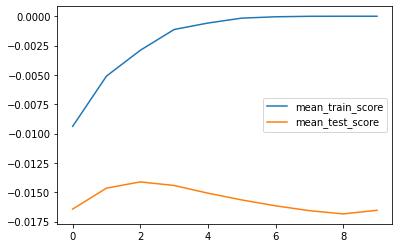

In [547]:
# XGBoost GridSearchCV
parameters = {
            # 'learning_rate': [0.1, 0.05, 0.01, 0.005]
            #    'subsample': np.arange(0.1, 1.1, 0.1),
            # 'colsample_bylevel': np.arange(0.1, 1.1, 0.1),
            # 'colsample_bynode': np.arange(0.1, 1.1, 0.1),
            #  'colsample_bytree': np.arange(0.1, 1.1, 0.1),
               'max_depth': np.arange(1, 11, 1),
            #   'gamma': [0, 0.5, 0.1, 0.01]
            #    'reg_alpha': np.arange(1, 2.1, 0.1),
}
model = xgb.XGBRegressor(n_estimators=5000, subsample=0.9, learning_rate=0.01,
                         colsample_bylevel=0.4, colsample_bynode=0.8,
                         colsample_bytree=0.5,
                         objective='reg:tweedie',
                         max_depth=3,
                         reg_alpha=1.5, gamma=0, reg_lambda=1, nthread=-1,
                         min_child_weight=0, n_jobs=-1,
                         tree_method='hist',
                        #  predictor='gpu_predictor',
                         verbosity=2, random_state=10)
model = GridSearchCV(estimator=model, param_grid=parameters, cv=5, verbose=2,
                     scoring='neg_mean_squared_log_error', n_jobs=-1, return_train_score=True)
model.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='rmsle', eval_set=[(X_val, y_val)])
result_grid_search = pd.DataFrame(model.cv_results_)
print(result_grid_search.loc[:,['params', 'mean_train_score', 'mean_test_score', 'rank_test_score']])
print('XGBoost 그리드서치의 최적 파라미터: {}'.format(model.best_params_))
print('XGBoost 그리드서치의 최고 모델: {}'.format(model.best_estimator_))
train_score_xgb = round(np.sqrt(MSLE(model.predict(X_train), y_train)), 3)
val_score_xgb = round(np.sqrt(MSLE(model.predict(X_val), y_val)), 3)
print('XGBoost 그리드서치의 훈련(검증) 세트 점수: {}({})'.format(train_score_xgb, val_score_xgb))
result_grid_search[['mean_train_score', 'mean_test_score']].plot()

In [548]:
# model = xgb.XGBRegressor(booster='gbtree', objective='reg:linear',
#                          n_estimators=5000, learning_rate=0.01,
#                          max_depth=5, subsample=0.7,
#                          colsample_bytree=0.7,
#                          min_child_weight=0, n_jobs=-1, nthread=-1,
#                          verbosity=2, random_state=10)
# model.fit(X_train, y_train, eval_metric='rmsle', early_stopping_rounds=100, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=True)
# print('XGBoost 모델: {}'.format(model))
# train_score = np.sqrt(MSLE(model.predict(X_train), y_train))
# print('XGBoost 훈련 세트 점수: {}'.format(round(train_score, 4)))
# val_score = np.sqrt(MSLE(model.predict(X_val), y_val))
# print('XGBoost 검증 세트 점수: {}'.format(round(val_score, 4)))

In [549]:
y_test = model.predict(X_test)
submission = pd.DataFrame({'Id': X_test_index, 'SalePrice': y_test})
submission.to_csv('/content/drive/MyDrive/Colab Notebooks/house_prices/submission.csv', index=False)

Text(0.5, 1.0, 'XGBoost')

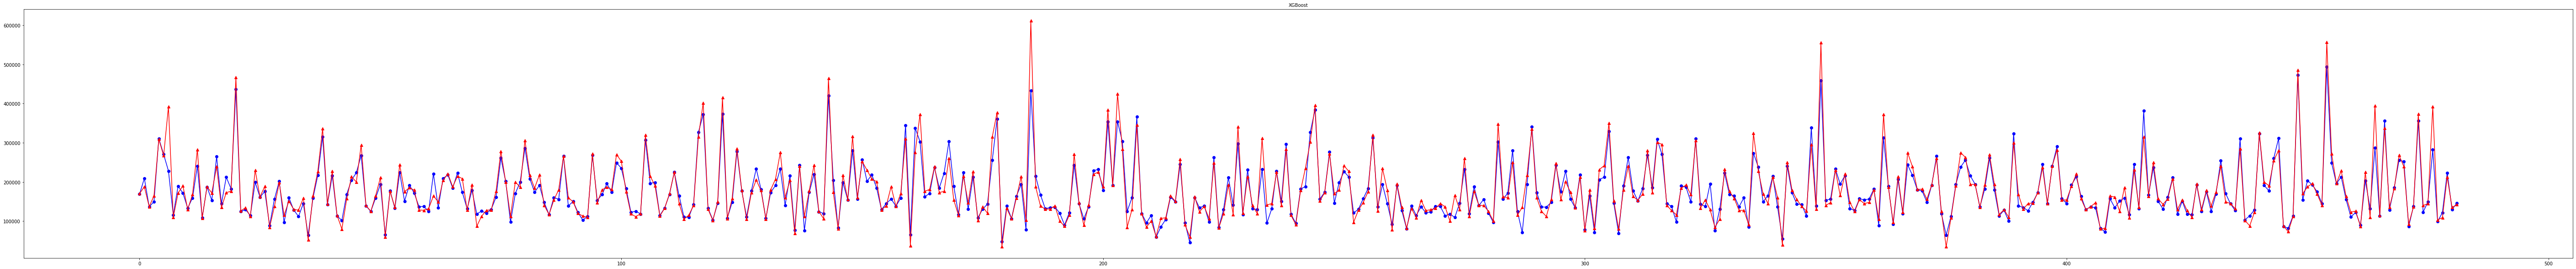

In [550]:
fig = plt.figure(figsize=(100, 10))
chart = fig.add_subplot(1, 1, 1)
chart.plot(model.predict(X_val), marker='o', color='blue', label='pred')
chart.plot(y_val.values, marker='^', color='red', label='real')
chart.set_title('XGBoost', size=10)

In [551]:
perm = PermutationImportance(model, scoring='neg_mean_squared_log_error', random_state=10).fit(X_val, y_val) 
eli5.show_weights(perm, top=None, feature_names=keys.tolist())
# sorted(sklearn.metrics.SCORERS.keys())

Weight,Feature
0.0078 ± 0.0014,GrLivArea_OverallQual
0.0075 ± 0.0014,TotalArea
0.0050 ± 0.0009,TotalSqrFootage
0.0044 ± 0.0012,TotalHouse
0.0042 ± 0.0009,OverallQual
0.0028 ± 0.0010,LotArea_OverallQual
0.0020 ± 0.0010,YrSoldSinceYearBuilt
0.0017 ± 0.0004,MSZoning
0.0015 ± 0.0002,YrSoldSinceYearRemodAdd
0.0014 ± 0.0008,OverallCond


In [552]:
# series = pd.Series(model.feature_importances_, index=keys).sort_values(ascending=True)
# series.plot.barh(figsize=(20, 200))